In [1]:
from init_nb import init_notebook
config = init_notebook()

from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import numpy as np
import seaborn as sns
import math
from nilearn import plotting
import nibabel as nib
import itertools
from bold_dementia.connectivity import (
    Atlas, group_by_networks, plot_matrix, reshape_pvalues, block_block, plot_ordered_matrix
)
from bold_dementia.utils.iterables import unique
from bold_dementia.data.synthetic import generate_topology_net_interaction

ATLAS = "schaeffer200"
ALPHA = config["alpha"]
atlas = Atlas.from_name(ATLAS)

In [2]:
maps_path = Path(config['output_dir']) / f"connectivity/atlas-{ATLAS}_merged-cov"

AD_matrices = joblib.load(maps_path / "converter_M000.joblib")
control_matrices = joblib.load(maps_path / "control_M000.joblib")
AD_df = pd.read_csv(maps_path / "balanced_converter_M000.csv", index_col=0)

#control_selection = len(control_matrices) // len(AD_matrices)
control_df = pd.read_csv(maps_path / "balanced_control_M000.csv", index_col=0)
metadata = pd.concat((AD_df, control_df))

In [3]:
tuple(unique(atlas.macro_labels))

('Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default')

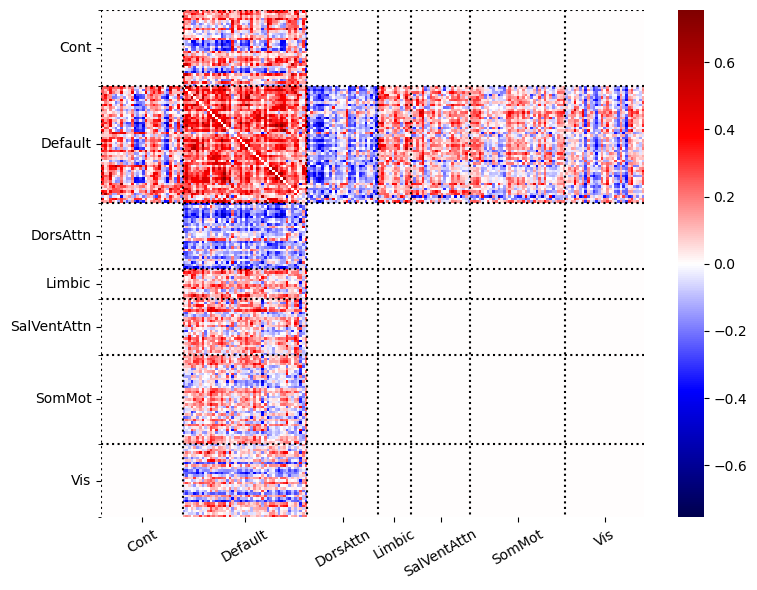

In [4]:
reference_net = "Default"
mask = generate_topology_net_interaction(
    (reference_net, reference_net), atlas.macro_labels
)
nets = unique(atlas.macro_labels)
for net in nets:
    mask += generate_topology_net_interaction(
    (reference_net, net), atlas.macro_labels
    )
    
mask = np.where(mask != 0, 1, 0)
subgraph = control_matrices[1] * mask
plot_matrix(subgraph, atlas)
plt.show()

In [5]:
#l = int(math.sqrt(mask.sum()))
#control_matrices = control_matrices[:, mask.astype(bool)].reshape(len(control_matrices), l, l)
#AD_matrices = AD_matrices[:, mask.astype(bool)].reshape(len(AD_matrices), l, l)
control_matrices *= mask
AD_matrices *= mask

In [6]:
from matplotlib import colormaps
colors = colormaps["tab20"].colors
cmapping = dict(zip(
    unique(atlas.macro_labels),
    colors
))

In [7]:
import networkx as nx

def graph_from_mat(mat):
    mat = np.where(abs(mat) < 1e-1, 0, mat)
    indexer = list(range(len(mat)))
    mat[indexer, indexer] = 0 # Remove self loops
    H = nx.from_numpy_array(mat)
    return H
    

def plot_fc(arr_nonsparse, thresh=0.01):
    G = graph_from_mat(arr_nonsparse)
    edge_values = [G.get_edge_data(u, v)["weight"] for u, v in G.edges()]
    edge_width = np.abs(edge_values)
    edge_color = ["blue" if v < 0 else "red" for v in edge_values]
    node_color = [cmapping[net] for net in atlas.macro_labels]
    
    pos = nx.spring_layout(G, seed=config["seed"])
    nx.draw_networkx_edges(G, pos, alpha=0.3, width=edge_width, edge_color=edge_color)
    nx.draw_networkx_nodes(G, pos, node_color=node_color, alpha=0.4)
    return pos

In [8]:
cmapping

{'Vis': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'SomMot': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 'DorsAttn': (1.0, 0.4980392156862745, 0.054901960784313725),
 'SalVentAttn': (1.0, 0.7333333333333333, 0.47058823529411764),
 'Limbic': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 'Cont': (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 'Default': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)}

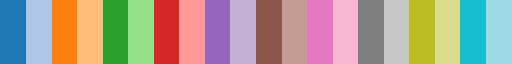

In [9]:
colormaps["tab20"]

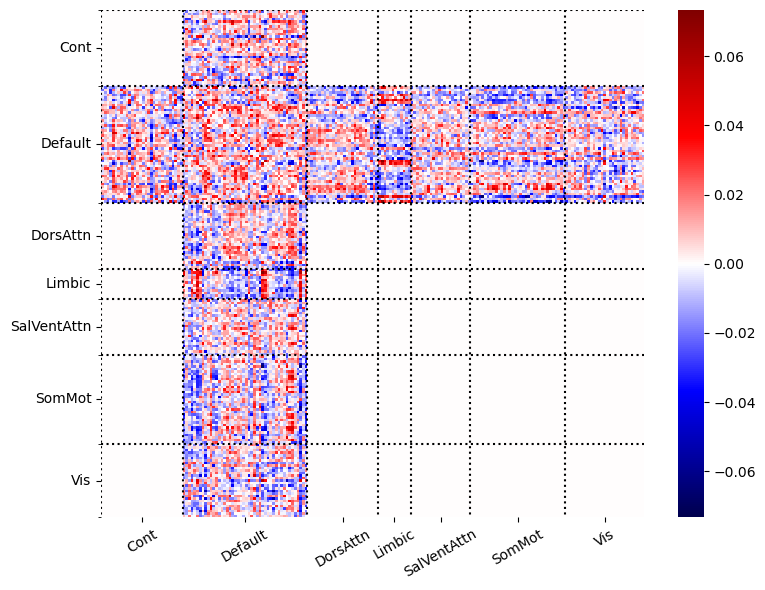

In [10]:
from bold_dementia.connectivity import plot_matrix, Atlas

plot_matrix(control_matrices.mean(axis=0) - AD_matrices.mean(axis=0), atlas)
plt.show()

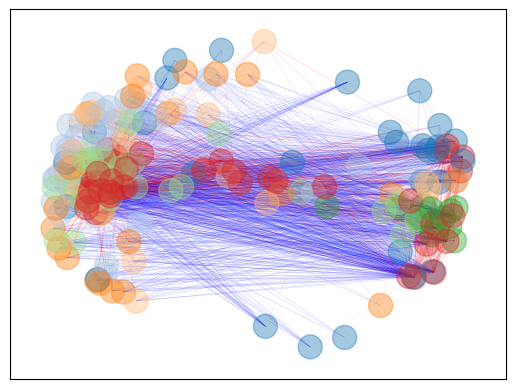

In [11]:
layout = plot_fc(control_matrices[:100].mean(axis=0))

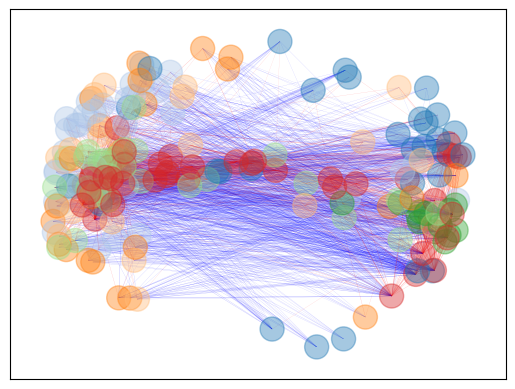

In [12]:
layout = plot_fc(AD_matrices[:100].mean(axis=0))

In [13]:
# Conversion function in the litterature?
def high_is_efficient(source, target, edge_attrs):
    """The more fc, the smaller the distance should be
    """
    w = edge_attrs["weight"]
    return abs(1/w)

def bin_fc(source, target, edge_attrs):
    w = edge_attrs["weight"]
    if abs(w) < 0.1:
        return np.inf
    else:
        return 1
        
from joblib import Parallel, delayed


def all_pairs_path_length(G, weight, n_jobs=1):
    length = nx.single_source_dijkstra_path_length
    parallel = Parallel(n_jobs=n_jobs, return_as="generator", verbose=5)
    calls = (delayed(length)(G, n, weight=weight) for n in G)
    return parallel(calls)

def all_pairs_path_length_serial(G, weight):
    """
    This function is going to be inside a joblib worker,
    so we can't use a generator
    """
    length = nx.single_source_dijkstra_path_length
    res = []
    for n in G:
        res.append(length(G, n, weight=weight))
    return res

def weighted_global_efficiency(G):

    n = len(G)
    denom = n * (n - 1)

    if denom == 0:
        return 0

    lengths = all_pairs_path_length_serial(
        G, weight=high_is_efficient
    )
    g_eff = 0
    for targets in lengths:
        # TODO Rewrite this loop in numpy
        for distance in targets.values():
            if distance > 0:
                g_eff += 1 / distance
    g_eff /= denom
    return g_eff

In [14]:
# TODO rich club
def run_computations(mat, label):

    #  TODO Make func for mat to graph
    H = graph_from_mat(mat)

    return (
        weighted_global_efficiency(H),
        nx.average_clustering(H),
        #nx.average_node_connectivity(H),
        label
    )
    
def efficiency(mats, label):
    parallel = Parallel(n_jobs=10, verbose=5, return_as="generator")
    calls = (delayed(run_computations)(mat, label) for mat in mats)
    yield from parallel(calls)
        
cols = ["eff", "clustering", "avg_conn", "label"]
cols = ["eff", "clustering", "label"]
c = pd.DataFrame(efficiency(control_matrices, "control"), columns=cols)
a = pd.DataFrame(efficiency(AD_matrices, "converter"), columns=cols)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    5.2s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:   12.3s
[Parallel(n_jobs=10)]: Done 268 tasks      | elapsed:   21.8s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   34.7s
[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed:   50.2s
[Parallel(n_jobs=10)]: Done 862 tasks      | elapsed:  1.1min
[Parallel(n_jobs=10)]: Done 922 out of 922 | elapsed:  1.2min finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:   11.7s
[Parallel(n_jobs=10)]: Done 173 out of 173 | elapsed:   14.1s finished


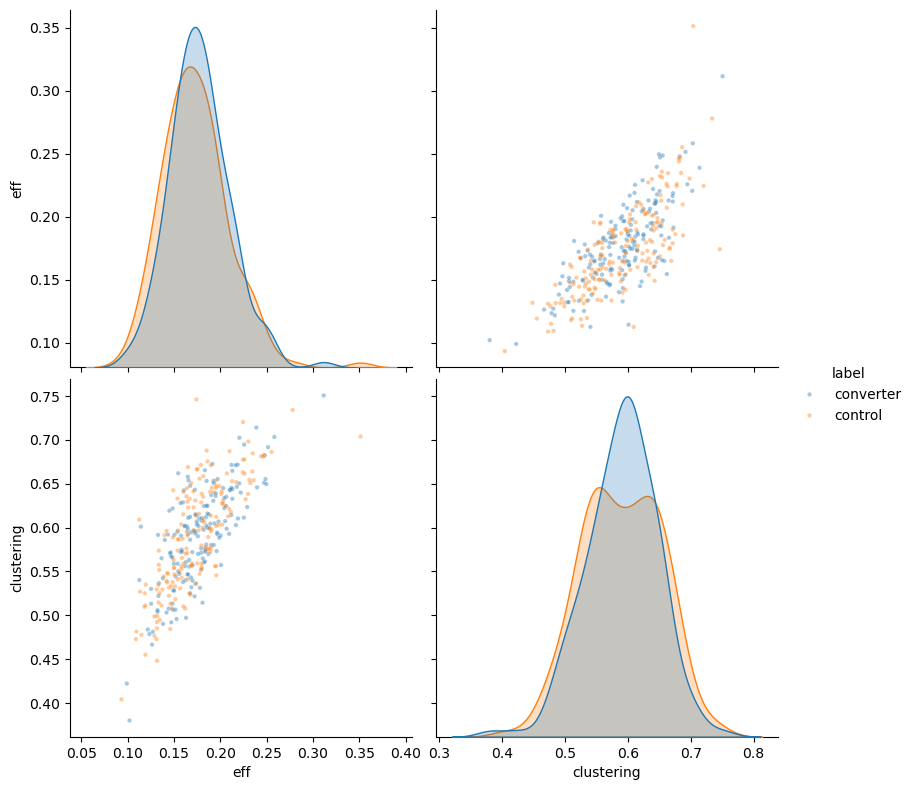

In [15]:
df = pd.concat([a, c.sample(n=len(a))])
df["rlabel"] = df["label"].sample(n=len(df), random_state=1234).values
sns.pairplot(df, hue="label", plot_kws={"alpha": 0.4, "s": 10}, height=4)
plt.show()

In [16]:
left = pd.concat([a, c])
res = pd.merge(
    left,
    metadata,
    left_index=True,
    right_index=True
)
res["CDRSCR"] = res.CDRSCR.replace("F", math.nan).astype(float).astype(str)

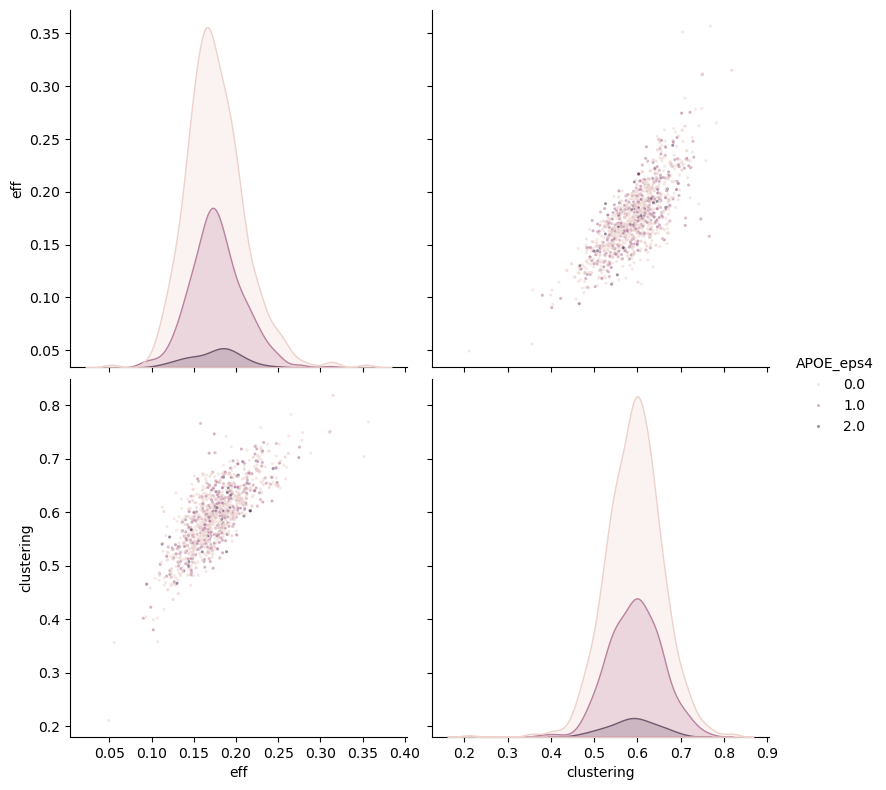

In [17]:
sns.pairplot(res[["eff", "clustering", "APOE_eps4"]], hue="APOE_eps4", height=4, plot_kws=dict(alpha=0.5, s=5))

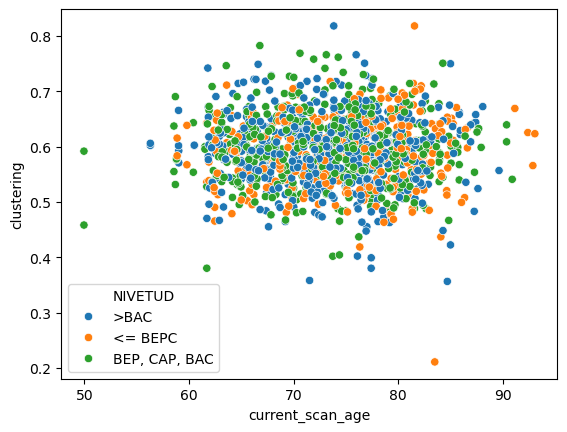

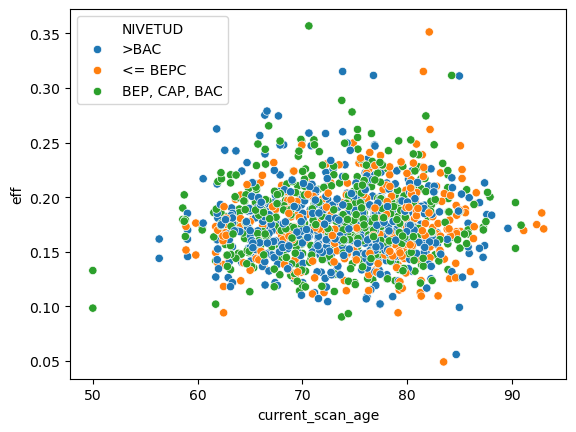

In [18]:
h = "NIVETUD"
sns.scatterplot(res, x="current_scan_age", y="clustering", hue=h)
plt.show()
sns.scatterplot(res, x="current_scan_age", y="eff", hue=h)
plt.show()